# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Determine the diffraction shifts
4. Calculate lattice vectors
5. Refine lattice vectors
6. **Calculate strain**
7. Visualize strain maps

# Notebook 6: Calculate strain

In this step the strain is calculated from the lattice vectors at each scan position.

* Get reference lattice(s)
    * Segment diffraction patterns
    * Within each segmentation region, calculate average lattice vectors
* For each diffraction pattern:
    * Calculate strain with respect to reference lattice
    
Issue to consider in the future: with sufficiently small grains, the approach of using the average of a single segmentation region (grain) as the reference lattice seems problematic.  What if the whole grain is strained?  Seems that perhaps it might make more sense to define the *directions* of the local reference lattice from the average of the current grain, and the *lengths* of the reference lattice from the average lengths of all diffraction patterns along the same zone axes.  This may end up requiring fine tuning for particular systems (i.e. what if there are chemical difference across multiple small grains?).  Things to consider.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit
from time import time
from gc import collect
from numpy.linalg import lstsq
from scipy.ndimage.morphology import binary_closing
from scipy.ndimage.filters import maximum_filter
from scipy.signal import medfilt

from py4DSTEM.process.datastructure import DataCube, DiffractionSlice, RealSlice, PointList, PointListArray

In [2]:
# # Load the raw data
# fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/h5/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5"
# dc = py4DSTEM.readwrite.read_data(fp)
# dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

# # Load the lattice vectors maps
# fp_uvmap = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/lattice_vector_maps.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_uvmap)
# browser.show_dataobjects()
# uv_map = browser.get_dataobject(0)

# # Load the DF image
# fp_DFimage = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/DF_image.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_DFimage)
# browser.show_dataobjects()
# DFimage = browser.get_dataobject(0)

In [5]:
# Load the raw data
fp = "/home/ben/Data/20180905_FePO4_unlithiated/h5/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5"
dc = py4DSTEM.readwrite.read_data(fp)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

# Load the lattice vectors maps
fp_uvmap = "/home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vector_maps.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_uvmap)
browser.show_dataobjects()
uv_map = browser.get_dataobject(0)

# Load the DF image
fp_DFimage = "/home/ben/Data/20180905_FePO4_unlithiated/processing/DF_image.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_DFimage)
browser.show_dataobjects()
DF_image = browser.get_dataobject(0)

Reading file /home/ben/Data/20180905_FePO4_unlithiated/h5/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5...

/home/ben/Data/20180905_FePO4_unlithiated/h5/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5 is a py4DSTEM HDF5 file.  Reading...
 Index                  Name                        Type        
   0    realslice_0                         RealSlice           
 Index                  Name                        Type        
   0    realslice_0                         RealSlice           


### Segment

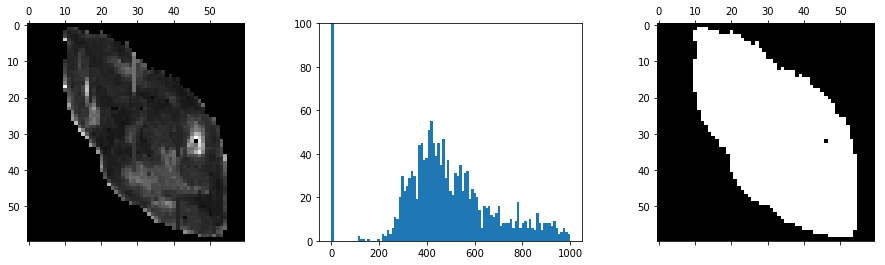

In [13]:
# Make a mask from the virtual dark-field image

mask = (DF_image.data2D>0)
#mask = binary_closing(mask)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
ax1.matshow(DF_image.data2D)
ax2.hist(DF_image.data2D.ravel(),bins=np.linspace(0,1000,100))
ax2.set_ylim([0,100])
ax3.matshow(mask)
plt.show()

### Calculate reference lattice

## Single Diffraction Pattern

In [5]:
# Select DP, get the Bragg peaks for this DP, filter low intensity peaks

rx,ry = 30,30
minRelativeIntensity = 0.02

Bragg_peaks_current_DP = Bragg_peaks.get_pointlist(rx,ry)
deletemask = Bragg_peaks_current_DP.data['intensity']/max(Bragg_peaks_current_DP.data['intensity']) < minRelativeIntensity
Bragg_peaks_current_DP.remove_points(deletemask)

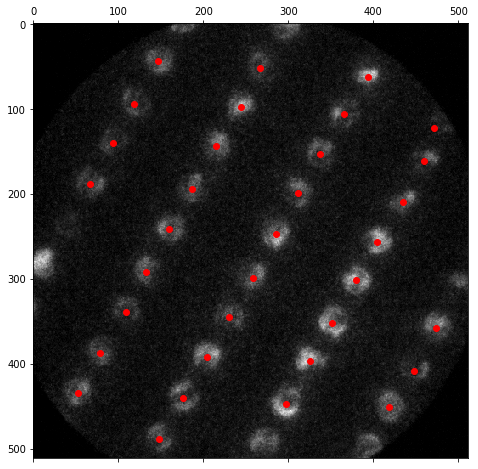

In [6]:
# Show

DP = dc.data4D[ry,rx,:,:]

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
plt.show()

### Determine the Bragg peak indices using the initial u,v guess

In [7]:
# Get the lattice vector matrix (a.k.a. beta)

u_x = lattice_vectors.data['length'][0]*np.cos(lattice_vectors.data['angle'][0]*np.pi/180.)
u_y = lattice_vectors.data['length'][0]*np.sin(lattice_vectors.data['angle'][0]*np.pi/180.)
v_x = lattice_vectors.data['length'][1]*np.cos(lattice_vectors.data['angle'][1]*np.pi/180.)
v_y = lattice_vectors.data['length'][1]*np.sin(lattice_vectors.data['angle'][1]*np.pi/180.)


uv = np.array([[u_x, u_y],[v_x, v_y]])

In [8]:
# Get central peak

x0,y0 = np.unravel_index(np.argmax(deconvolution.data2D),deconvolution.data2D.shape)

ind = np.argmin((Bragg_peaks_current_DP.data['qx']-x0)**2 + (Bragg_peaks_current_DP.data['qy']-y0)**2)
x_beam,y_beam = Bragg_peaks_current_DP.data['qx'][ind],Bragg_peaks_current_DP.data['qy'][ind]

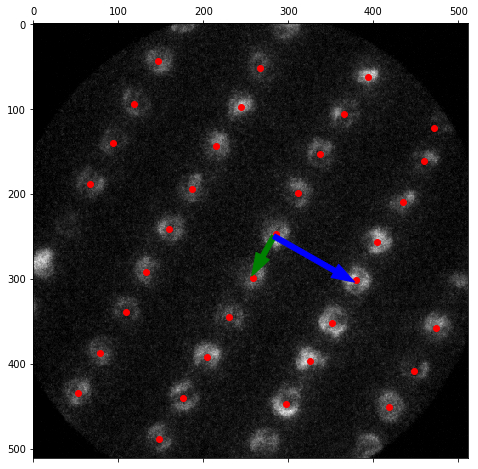

In [9]:
# Show

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
ax.arrow(y0,x0,u_x,u_y, color='green',width=6,length_includes_head=True)
ax.arrow(y0,x0,v_x,v_y, color='blue',width=6,length_includes_head=True)
plt.show()

In [10]:
# Get array of measured Bragg peak positions (a.k.a. alpha), using the central beam as the origin
x = Bragg_peaks_current_DP.data['qx'].reshape(Bragg_peaks_current_DP.length,1) - x_beam
y = Bragg_peaks_current_DP.data['qy'].reshape(Bragg_peaks_current_DP.length,1) - y_beam
Bragg_peak_positions = np.hstack((y,x))

In [11]:
# Get Bragg peak indices

M = lstsq(uv.T, Bragg_peak_positions.T,rcond=None)[0].T
M = np.round(M)

#### A note on solving for $M$ (or: what's up with all the .T's?)
Given an equation of the form $M\beta = \alpha$, the matrix equation solver numpy.linalg.lstsq will solve for $\beta$ given $M$ and $\alpha$.  So when solving for $M$, before passing it to the solver we need to rearrange the matrix equation at the beginning of the notebook as follows:

\begin{equation}
\begin{pmatrix}
u_x   &   v_x   \\
u_y   &   v_y
\end{pmatrix}
\begin{pmatrix}
& a & \\
\ldots   & &   \ldots   \\
&b&
\end{pmatrix}
=
\begin{pmatrix}
& g^{ab}_x & \\
\ldots   & &   \ldots   \\
& g^{ab}_y &
\end{pmatrix}
\end{equation}

Which is equivalent to
\begin{equation}
\beta^T M^T = \alpha^T
\end{equation}
where $A^T$ is the transpose of $A$.

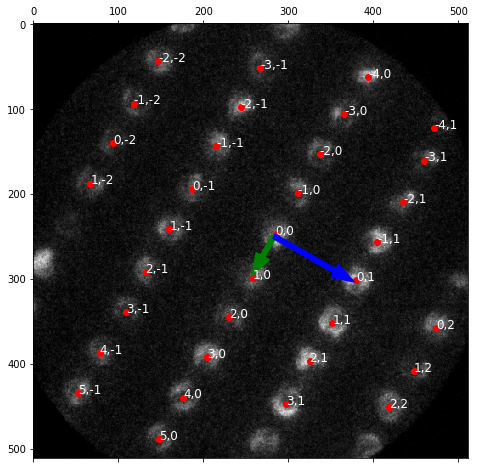

In [12]:
# Show

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
ax.arrow(y0,x0,u_x,u_y, color='green',width=6,length_includes_head=True)
ax.arrow(y0,x0,v_x,v_y, color='blue',width=6,length_includes_head=True)
for i in range(Bragg_peaks_current_DP.length):
    ax.text(Bragg_peaks_current_DP.data['qy'][i],Bragg_peaks_current_DP.data['qx'][i],
            '{},{}'.format(int(M[i,0]),int(M[i,1])),color='w',size=12)
plt.show()

### Refine lattice vectors

In [13]:
iterations = 5

for i in range(5):
    # Add a column for shifting the origin in the coefficient's matrix
    basis = np.column_stack((np.ones(len(M)),M))

    # Get weighted matrices
    weights = Bragg_peaks_current_DP.data['intensity']
    weighted_basis = basis*np.sqrt(weights[:,np.newaxis])
    weighted_Bragg_peak_positions = Bragg_peak_positions*np.sqrt(weights[:,np.newaxis])

    # Solve for lattice vectors (beta)
    beta = lstsq(weighted_basis, weighted_Bragg_peak_positions,rcond=None)[0]

    # Solve for peak indices (M)
    uv = beta[1:,:]
    Bragg_peak_positions_shifted = Bragg_peak_positions-np.tile(beta[0,:],(len(M),1))
    M = lstsq(uv.T, Bragg_peak_positions_shifted.T,rcond=None)[0].T

#### A note on shifting the origin (or: why the extra column in basis, a.k.a. M?)

The final tweak we'll make in the equations we're solving is to additionally fit the origin of the coordinate system.  This is included with the extra parameter $\mathbf{r}^0 = r^0_x\mathbf{\hat{x}} + r^0_y\mathbf{\hat{y}}$ - to wit: 

\begin{align*}
r^0_x + a \cdot u_x + b \cdot v_x = g^{ab}_x \\
r^0_y + a \cdot u_y + b \cdot v_y = g^{ab}_y
\end{align*}

Or, as a matrix equation:
\begin{equation}
\begin{pmatrix}
&\vdots& \\
1 & a   &   b   \\
&\vdots&
\end{pmatrix}
\begin{pmatrix}
r^0_x   &   r^0_y   \\
u_x   &   u_y   \\
v_x   &   v_y
\end{pmatrix}
=
\begin{pmatrix}
&\vdots& \\
g^{ab}_x   & &   g^{ab}_y   \\
&\vdots&
\end{pmatrix}
\end{equation}

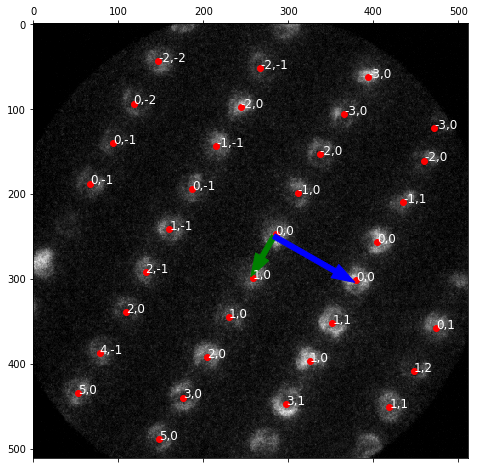

In [14]:
# Show

u_x = uv[0,0]
u_y = uv[0,1]
v_x = uv[1,0]
v_y = uv[1,1]

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
ax.arrow(y0,x0,u_x,u_y, color='green',width=6,length_includes_head=True)
ax.arrow(y0,x0,v_x,v_y, color='blue',width=6,length_includes_head=True)
for i in range(Bragg_peaks_current_DP.length):
    ax.text(Bragg_peaks_current_DP.data['qy'][i],Bragg_peaks_current_DP.data['qx'][i],
            '{},{}'.format(int(M[i,0]),int(M[i,1])),color='w',size=12)
plt.show()

In [15]:
# Calculate the error
basis = np.column_stack((np.ones(len(M)),M))
Bragg_peak_positions_calculated = np.matmul(basis, beta)

fit_error = np.sqrt(np.sum((Bragg_peak_positions - Bragg_peak_positions_calculated)**2,axis=1))
weighted_fit_error = np.sum(fit_error*weights)/np.sum(weights)

## All diffraction patterns 

In [16]:
minRelativeIntensity = 0.02
minNumPeaks = 6
iterations = 5

# Guess at unscattered beam position
x0,y0 = np.unravel_index(np.argmax(deconvolution.data2D),deconvolution.data2D.shape)

# Make containers for outputs
slicelabels = ('ux','uy','vx','vy','fit_error','mask')
uv_map = RealSlice(data=np.zeros((6,dc.R_Ny,dc.R_Nx)),parentDataCube=dc,slicelabels=slicelabels)
DF_image = RealSlice(data=np.zeros((dc.R_Ny,dc.R_Nx)),parentDataCube=dc)

t0=time()
for Ri in range(dc.R_Nx):
    for Rj in range(dc.R_Ny):
        print("Analyzing scan position {},{}".format(Ri,Rj))

        # Get Bragg peaks for current DP
        Bragg_peaks_current_DP = Bragg_peaks.get_pointlist(Ri,Rj)
        deletemask = Bragg_peaks_current_DP.data['intensity']/max(Bragg_peaks_current_DP.data['intensity']) < minRelativeIntensity
        Bragg_peaks_current_DP.remove_points(deletemask)
        
        # Check if minimum number of peaks are present
        if Bragg_peaks_current_DP.length > minNumPeaks:
        
            # Get central peak
            ind = np.argmin((Bragg_peaks_current_DP.data['qx']-x0)**2 + (Bragg_peaks_current_DP.data['qy']-y0)**2)
            x_beam,y_beam= Bragg_peaks_current_DP.data['qx'][ind],Bragg_peaks_current_DP.data['qy'][ind]

            # Get array of measured Bragg peak positions (a.k.a. alpha), using the central beam as the origin
            x = Bragg_peaks_current_DP.data['qx'].reshape(Bragg_peaks_current_DP.length,1) - x_beam
            y = Bragg_peaks_current_DP.data['qy'].reshape(Bragg_peaks_current_DP.length,1) - y_beam
            Bragg_peak_positions = np.hstack((y,x))

            # Get Bragg peak indices
            M = lstsq(uv.T, Bragg_peak_positions.T,rcond=None)[0].T
            M = np.round(M)

            # Refine lattice vectors
            for i in range(5):
                # Add a column for shifting the origin in the coefficient's matrix
                basis = np.column_stack((np.ones(len(M)),M))

                # Get weighted matrices
                weights = Bragg_peaks_current_DP.data['intensity']
                weighted_basis = basis*np.sqrt(weights[:,np.newaxis])
                weighted_Bragg_peak_positions = Bragg_peak_positions*np.sqrt(weights[:,np.newaxis])

                # Solve for lattice vectors (beta)
                beta = lstsq(weighted_basis, weighted_Bragg_peak_positions,rcond=None)[0]

                # Solve for peak indices (M)
                uv = beta[1:,:]
                Bragg_peak_positions_shifted = Bragg_peak_positions-np.tile(beta[0,:],(len(M),1))
                M = lstsq(uv.T, Bragg_peak_positions_shifted.T,rcond=None)[0].T

            # Calculate the error
            basis = np.column_stack((np.ones(len(M)),M))
            Bragg_peak_positions_calculated = np.matmul(basis, beta)

            fit_error = np.sqrt(np.sum((Bragg_peak_positions - Bragg_peak_positions_calculated)**2,axis=1))
            weighted_fit_error = np.sum(fit_error*weights)/np.sum(weights)

            # Store data
            uv_map.data2D['ux'][Rj,Ri] = uv[0,0]
            uv_map.data2D['uy'][Rj,Ri] = uv[0,1]
            uv_map.data2D['vx'][Rj,Ri] = uv[1,0]
            uv_map.data2D['vy'][Rj,Ri] = uv[1,1]
            uv_map.data2D['fit_error'][Rj,Ri] = weighted_fit_error
            DF_image.data2D[Rj,Ri] = np.sum(Bragg_peaks_current_DP.data['intensity'][1:])
        
        # If minimum number of peaks are not present, populate mask
        uv_map.data2D['mask'][Rj,Ri] = 1
        
t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Analyzing scan position 0,0
Analyzing scan position 0,1
Analyzing scan position 0,2
Analyzing scan position 0,3
Analyzing scan position 0,4
Analyzing scan position 0,5
Analyzing scan position 0,6
Analyzing scan position 0,7
Analyzing scan position 0,8
Analyzing scan position 0,9
Analyzing scan position 0,10
Analyzing scan position 0,11
Analyzing scan position 0,12
Analyzing scan position 0,13
Analyzing scan position 0,14
Analyzing scan position 0,15
Analyzing scan position 0,16
Analyzing scan position 0,17
Analyzing scan position 0,18
Analyzing scan position 0,19
Analyzing scan position 0,20
Analyzing scan position 0,21
Analyzing scan position 0,22
Analyzing scan position 0,23
Analyzing scan position 0,24
Analyzing scan position 0,25
Analyzing scan position 0,26
Analyzing scan position 0,27
Analyzing scan position 0,28
Analyzing scan position 0,29
Analyzing scan position 0,30
Analyzing scan position 0,31
Analyzing scan position 0,32
Analyzing scan position 0,33
Analyzing scan position 

Analyzing scan position 15,16
Analyzing scan position 15,17
Analyzing scan position 15,18
Analyzing scan position 15,19
Analyzing scan position 15,20
Analyzing scan position 15,21
Analyzing scan position 15,22
Analyzing scan position 15,23
Analyzing scan position 15,24
Analyzing scan position 15,25
Analyzing scan position 15,26
Analyzing scan position 15,27
Analyzing scan position 15,28
Analyzing scan position 15,29
Analyzing scan position 15,30
Analyzing scan position 15,31
Analyzing scan position 15,32
Analyzing scan position 15,33
Analyzing scan position 15,34
Analyzing scan position 15,35
Analyzing scan position 15,36
Analyzing scan position 15,37
Analyzing scan position 15,38
Analyzing scan position 15,39
Analyzing scan position 15,40
Analyzing scan position 15,41
Analyzing scan position 15,42
Analyzing scan position 15,43
Analyzing scan position 15,44
Analyzing scan position 15,45
Analyzing scan position 15,46
Analyzing scan position 15,47
Analyzing scan position 15,48
Analyzing 

Analyzing scan position 20,5
Analyzing scan position 20,6
Analyzing scan position 20,7
Analyzing scan position 20,8
Analyzing scan position 20,9
Analyzing scan position 20,10
Analyzing scan position 20,11
Analyzing scan position 20,12
Analyzing scan position 20,13
Analyzing scan position 20,14
Analyzing scan position 20,15
Analyzing scan position 20,16
Analyzing scan position 20,17
Analyzing scan position 20,18
Analyzing scan position 20,19
Analyzing scan position 20,20
Analyzing scan position 20,21
Analyzing scan position 20,22
Analyzing scan position 20,23
Analyzing scan position 20,24
Analyzing scan position 20,25
Analyzing scan position 20,26
Analyzing scan position 20,27
Analyzing scan position 20,28
Analyzing scan position 20,29
Analyzing scan position 20,30
Analyzing scan position 20,31
Analyzing scan position 20,32
Analyzing scan position 20,33
Analyzing scan position 20,34
Analyzing scan position 20,35
Analyzing scan position 20,36
Analyzing scan position 20,37
Analyzing scan 

Analyzing scan position 29,17
Analyzing scan position 29,18
Analyzing scan position 29,19
Analyzing scan position 29,20
Analyzing scan position 29,21
Analyzing scan position 29,22
Analyzing scan position 29,23
Analyzing scan position 29,24
Analyzing scan position 29,25
Analyzing scan position 29,26
Analyzing scan position 29,27
Analyzing scan position 29,28
Analyzing scan position 29,29
Analyzing scan position 29,30
Analyzing scan position 29,31
Analyzing scan position 29,32
Analyzing scan position 29,33
Analyzing scan position 29,34
Analyzing scan position 29,35
Analyzing scan position 29,36
Analyzing scan position 29,37
Analyzing scan position 29,38
Analyzing scan position 29,39
Analyzing scan position 29,40
Analyzing scan position 29,41
Analyzing scan position 29,42
Analyzing scan position 29,43
Analyzing scan position 29,44
Analyzing scan position 29,45
Analyzing scan position 29,46
Analyzing scan position 29,47
Analyzing scan position 29,48
Analyzing scan position 29,49
Analyzing 

Analyzing scan position 34,20
Analyzing scan position 34,21
Analyzing scan position 34,22
Analyzing scan position 34,23
Analyzing scan position 34,24
Analyzing scan position 34,25
Analyzing scan position 34,26
Analyzing scan position 34,27
Analyzing scan position 34,28
Analyzing scan position 34,29
Analyzing scan position 34,30
Analyzing scan position 34,31
Analyzing scan position 34,32
Analyzing scan position 34,33
Analyzing scan position 34,34
Analyzing scan position 34,35
Analyzing scan position 34,36
Analyzing scan position 34,37
Analyzing scan position 34,38
Analyzing scan position 34,39
Analyzing scan position 34,40
Analyzing scan position 34,41
Analyzing scan position 34,42
Analyzing scan position 34,43
Analyzing scan position 34,44
Analyzing scan position 34,45
Analyzing scan position 34,46
Analyzing scan position 34,47
Analyzing scan position 34,48
Analyzing scan position 34,49
Analyzing scan position 34,50
Analyzing scan position 34,51
Analyzing scan position 34,52
Analyzing 

Analyzing scan position 39,18
Analyzing scan position 39,19
Analyzing scan position 39,20
Analyzing scan position 39,21
Analyzing scan position 39,22
Analyzing scan position 39,23
Analyzing scan position 39,24
Analyzing scan position 39,25
Analyzing scan position 39,26
Analyzing scan position 39,27
Analyzing scan position 39,28
Analyzing scan position 39,29
Analyzing scan position 39,30
Analyzing scan position 39,31
Analyzing scan position 39,32
Analyzing scan position 39,33
Analyzing scan position 39,34
Analyzing scan position 39,35
Analyzing scan position 39,36
Analyzing scan position 39,37
Analyzing scan position 39,38
Analyzing scan position 39,39
Analyzing scan position 39,40
Analyzing scan position 39,41
Analyzing scan position 39,42
Analyzing scan position 39,43
Analyzing scan position 39,44
Analyzing scan position 39,45
Analyzing scan position 39,46
Analyzing scan position 39,47
Analyzing scan position 39,48
Analyzing scan position 39,49
Analyzing scan position 39,50
Analyzing 

Analyzing scan position 44,19
Analyzing scan position 44,20
Analyzing scan position 44,21
Analyzing scan position 44,22
Analyzing scan position 44,23
Analyzing scan position 44,24
Analyzing scan position 44,25
Analyzing scan position 44,26
Analyzing scan position 44,27
Analyzing scan position 44,28
Analyzing scan position 44,29
Analyzing scan position 44,30
Analyzing scan position 44,31
Analyzing scan position 44,32
Analyzing scan position 44,33
Analyzing scan position 44,34
Analyzing scan position 44,35
Analyzing scan position 44,36
Analyzing scan position 44,37
Analyzing scan position 44,38
Analyzing scan position 44,39
Analyzing scan position 44,40
Analyzing scan position 44,41
Analyzing scan position 44,42
Analyzing scan position 44,43
Analyzing scan position 44,44
Analyzing scan position 44,45
Analyzing scan position 44,46
Analyzing scan position 44,47
Analyzing scan position 44,48
Analyzing scan position 44,49
Analyzing scan position 44,50
Analyzing scan position 44,51
Analyzing 

Analyzing scan position 49,34
Analyzing scan position 49,35
Analyzing scan position 49,36
Analyzing scan position 49,37
Analyzing scan position 49,38
Analyzing scan position 49,39
Analyzing scan position 49,40
Analyzing scan position 49,41
Analyzing scan position 49,42
Analyzing scan position 49,43
Analyzing scan position 49,44
Analyzing scan position 49,45
Analyzing scan position 49,46
Analyzing scan position 49,47
Analyzing scan position 49,48
Analyzing scan position 49,49
Analyzing scan position 49,50
Analyzing scan position 49,51
Analyzing scan position 49,52
Analyzing scan position 49,53
Analyzing scan position 49,54
Analyzing scan position 49,55
Analyzing scan position 49,56
Analyzing scan position 49,57
Analyzing scan position 49,58
Analyzing scan position 49,59
Analyzing scan position 50,0
Analyzing scan position 50,1
Analyzing scan position 50,2
Analyzing scan position 50,3
Analyzing scan position 50,4
Analyzing scan position 50,5
Analyzing scan position 50,6
Analyzing scan po

Analyzing scan position 57,41
Analyzing scan position 57,42
Analyzing scan position 57,43
Analyzing scan position 57,44
Analyzing scan position 57,45
Analyzing scan position 57,46
Analyzing scan position 57,47
Analyzing scan position 57,48
Analyzing scan position 57,49
Analyzing scan position 57,50
Analyzing scan position 57,51
Analyzing scan position 57,52
Analyzing scan position 57,53
Analyzing scan position 57,54
Analyzing scan position 57,55
Analyzing scan position 57,56
Analyzing scan position 57,57
Analyzing scan position 57,58
Analyzing scan position 57,59
Analyzing scan position 58,0
Analyzing scan position 58,1
Analyzing scan position 58,2
Analyzing scan position 58,3
Analyzing scan position 58,4
Analyzing scan position 58,5
Analyzing scan position 58,6
Analyzing scan position 58,7
Analyzing scan position 58,8
Analyzing scan position 58,9
Analyzing scan position 58,10
Analyzing scan position 58,11
Analyzing scan position 58,12
Analyzing scan position 58,13
Analyzing scan posit

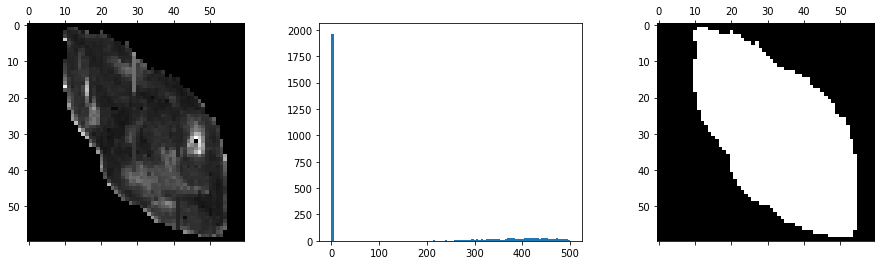

In [17]:
# Make a mask from the virtual dark-field image

mask = (DF_image.data2D>0)
mask = binary_closing(mask)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
ax1.matshow(DF_image.data2D)
ax2.hist(DF_image.data2D.ravel(),bins=np.linspace(0,500,100))
ax3.matshow(mask)
plt.show()

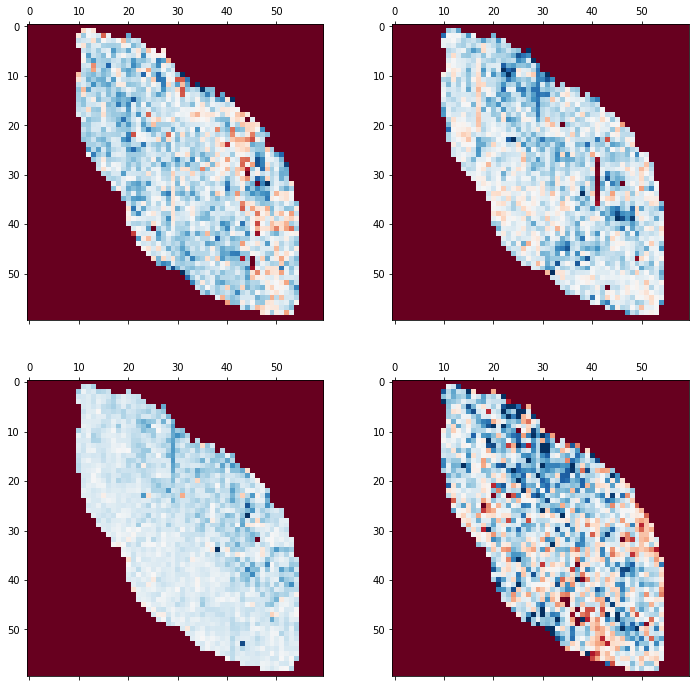

In [18]:
# Plot uncalibrated strains

n_stds = .3

u_lengths = np.sqrt(uv_map.data2D['ux']**2 + uv_map.data2D['uy']**2)
v_lengths = np.sqrt(uv_map.data2D['vx']**2 + uv_map.data2D['vy']**2)
u_length_ave, u_length_std = np.average(u_lengths[mask]), np.std(u_lengths[mask])
v_length_ave, v_length_std = np.average(v_lengths[mask]), np.std(v_lengths[mask])

u_angles = np.angle(uv_map.data2D['ux'] + 1j*uv_map.data2D['uy'])
v_angles = np.angle(uv_map.data2D['vx'] + 1j*uv_map.data2D['vy'])
u_angle_ave, u_angle_std = np.average(u_angles[mask]), np.std(u_angles[mask])
v_angle_ave, v_angle_std = np.average(v_angles[mask]), np.std(v_angles[mask])

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(u_lengths, vmin=u_length_ave-n_stds*u_length_std, vmax=u_length_ave+n_stds*u_length_std, cmap="RdBu")
ax12.matshow(v_lengths, vmin=v_length_ave-n_stds*v_length_std, vmax=v_length_ave+n_stds*v_length_std, cmap="RdBu")
ax21.matshow(u_angles, vmin=u_angle_ave-n_stds*u_angle_std, vmax=u_angle_ave+n_stds*u_angle_std, cmap="RdBu")
ax22.matshow(v_angles, vmin=v_angle_ave-n_stds*v_angle_std, vmax=v_angle_ave+n_stds*v_angle_std, cmap="RdBu")
plt.show()

/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


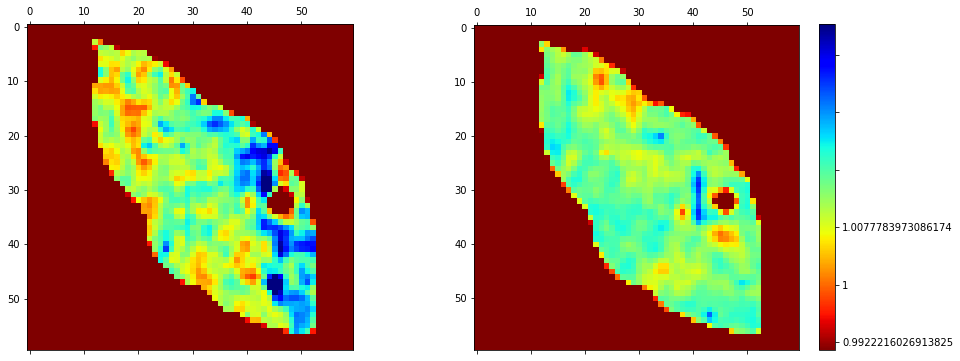

In [19]:
# Plot inverse u,v vector length with guassian blur

sigma=.8
n_stds = 1.5

u_length_inv = np.where(mask & (u_angles != 0), 1./u_lengths, 0)
v_length_inv = np.where(mask & (u_angles != 0), 1./v_lengths, 0)

u_lengthinv_ave, u_lengthinv_std = np.average(u_length_inv[u_length_inv!=0]), np.std(u_length_inv[u_length_inv!=0])
v_lengthinv_ave, v_lengthinv_std = np.average(v_length_inv[v_length_inv!=0]), np.std(v_length_inv[v_length_inv!=0])
std = max(u_lengthinv_std,v_lengthinv_std)
u_minval = u_lengthinv_ave-n_stds*std
u_maxval = u_lengthinv_ave+n_stds*std
v_minval = v_lengthinv_ave-n_stds*std
v_maxval = v_lengthinv_ave+n_stds*std

u_length_filt = gaussian_filter(u_length_inv,sigma)
v_length_filt = gaussian_filter(v_length_inv,sigma)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
cax1 = ax1.matshow(u_length_filt, vmin=u_minval, vmax=u_maxval, cmap="jet_r")
cax2 = ax2.matshow(v_length_filt, vmin=v_minval, vmax=v_maxval, cmap="jet_r")

cbar = fig.colorbar(cax1)
cbar.ax.set_yticklabels(['{}'.format(u_minval/u_lengthinv_ave), '{}'.format(1), '{}'.format(u_maxval/u_lengthinv_ave)])  # vertically oriented colorbar

plt.show()

### Save lattice vector maps

In [24]:
# Save

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vector_maps.h5"
py4DSTEM.readwrite.save_dataobject(uv_map,savepath)

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/DF_image.h5"
py4DSTEM.readwrite.save_dataobject(DF_image,savepath)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vector_maps.h5...
Writing metadata...
Done.
Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/DF_image.h5...
Writing metadata...
Done.


In [106]:
# # Save

# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/lattice_vector_maps.h5"
# py4DSTEM.readwrite.save_dataobject(uv_map,savepath)

# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/DF_image.h5"
# py4DSTEM.readwrite.save_dataobject(DF_image,savepath)